## Introduction

### In this notebook we use [Context-Conditional GAN (CCGAN)](https://arxiv.org/abs/1604.07379) to perform Image Inpainting on [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

<h4><center>Semantic Inpainting results on held-out images by Context Encoder.</center></h4>
<img src="http://people.eecs.berkeley.edu/~pathak/context_encoder/resources/result_fig.jpg" width="900" height="900"/>
<h4></h4>
<h4><center>Image Source:  <a href="https://arxiv.org/abs/1609.04802">Context Encoders: Feature Learning by Inpainting [Deepak Pathak et al.]</a></center></h4>

### Libraries 📚⬇

In [282]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

### Settings ⚙️

In [283]:
# load pretrained models
load_pretrained_models = False
# number of epochs of training
n_epochs = 20
# size of the batches
batch_size = 1
# name of the dataset
dataset_name = "../Data/img_align_celeba"
dataset_name = "../Data/genre_original/disco"
# adam: learning rate
# lr = 0.00008
lr = 0.00008


def lr_decay(global_step,
    init_learning_rate = 2,
    min_learning_rate = .002,
    decay_rate = 0.8):
    lr = ((init_learning_rate - min_learning_rate) *
          pow(decay_rate, global_step) +
          min_learning_rate)
    return lr

lr0 = lr_decay(0)




# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# number of cpu threads to use during batch generation
n_cpu = 4
# dimensionality of the latent space
latent_dim = 100
# size of each image dimension
img_size = 130560
# size of random mask
mask_size = 12500

mask_array_hieght = 1024
mask_array_width = 25
# number of image channels
channels = 3
# interval between image sampling
sample_interval = 100

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Calculate output dims of image discriminator (PatchGAN)
patch_h, patch_w = int(mask_array_hieght / 2 ** 3), int(mask_array_width / 4 ** 3)
#needed to adjust for the tiny width 24 for patch and 32 for whole
patch_w = 32
patch = (1, patch_h, patch_w)
full = (1, 1025, 256)

print(patch)

(1, 128, 32)


### STFT Experiment

stft: [[ 4.60542664e-02+0.0000000e+00j -4.43770617e-01+0.0000000e+00j
  -5.99667311e-01+0.0000000e+00j ... -3.60285223e-01+0.0000000e+00j
  -6.31443322e-01+0.0000000e+00j -3.85448486e-01+0.0000000e+00j]
 [-1.46420762e-01-5.6706911e-01j  3.34686935e-01+1.6043675e-01j
   6.35136843e-01-4.1177714e-01j ... -3.62014472e-02-5.0451890e-02j
   6.01221681e-01-2.0406917e-01j  7.97729194e-03+4.3300587e-01j]
 [ 5.78518987e-01+1.0901452e+00j -7.34995827e-02-8.3045483e-01j
   1.93367183e-01+1.0642042e+00j ...  2.49943033e-01-6.8545431e-01j
  -1.05798268e+00+4.9893191e-01j  5.36575496e-01+6.5025464e-02j]
 ...
 [ 2.71459017e-03-1.9027159e-04j -1.57325680e-03+1.7014075e-04j
   3.58845078e-04-3.5436373e-05j ... -1.69312358e-02+8.1507191e-03j
   2.73987763e-02-1.3132452e-02j -1.08408816e-02+5.1597315e-03j]
 [-2.48493184e-03+2.4046829e-04j  3.45612381e-04+1.1170162e-03j
  -1.36391856e-04-2.6543237e-05j ... -4.25701914e-03-1.8307278e-02j
  -2.97020469e-02+6.7816423e-03j  2.64718803e-03+1.1712914e-02j]
 [ 2

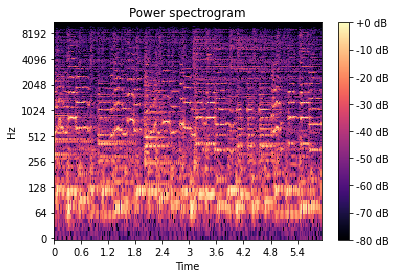

In [284]:
import librosa
import soundfile as sf
from librosa import display
import numpy as np
import torch 
import torchvision 
import torchvision.transforms as T 
from PIL import Image 
import matplotlib.pyplot as plt
import torchaudio

sample_path = '../Data/genres_original/jazz/jazz.00005.wav'
# sample_path = 'testStuff/20.wav'
y, sr = librosa.load(sample_path)
# for x in range(15000, 45000):
#     y[x] = 0
D = librosa.stft(y)
y_hat = librosa.istft(D)
# print(f'istft: {y_hat}')
# print(f'sr: {sr}')


# NEW LENGTH GOAL 131129

musicLen = 131000
y = y[:musicLen]
n_fft = 2048
y_pad = librosa.util.fix_length(y, size=musicLen + n_fft // 2)
D = librosa.stft(y_pad, n_fft=n_fft)
y_out = librosa.istft(D, length=musicLen)
adjustedN = math.ceil(23000/661794)
print(f'stft: {D}')
print(f'stft: {D.shape}')
print(f'istft size: {y_out.size}')
print(f'max: {np.min(np.abs(y_out))}')
masked_part = y_out.copy()[15000:27500]
d = librosa.stft(masked_part, n_fft=n_fft)
print(f'XXXXXXXXXXX d : {d.shape}')
print(d.shape)
d_out = librosa.istft(d, length=12500)
print(f'd_out size = {len(d_out)}')

transform = T.Resize(size = (512,512))
# for x in range(15000, 27500):
#     y_out[x] = 0


# print(f'D: {D.shape}')
# D = transform(D)
# print(f'D: {D.shape}')
# transform2 = T.Resize(size=(1025, 1295))
# D = transform2(D)

# y_out = librosa.istft(D, length=n)
# print(f'D: {D.shape}')

# y_out[15000: 27500] = d_out
# d_out = d_out[:musicLen*adjustedN]

D = librosa.stft(y_out, n_fft=n_fft)
D = torch.FloatTensor([librosa.stft(y_out, n_fft=n_fft)])
originalShape = D.shape
D = D[0].numpy()

sf.write('../Data/genres_original/bluesTest/blues.00000.wav', y_out, sr)

S = np.abs(D)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")




### Define Dataset Class

In [285]:
class AudioDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=131000, mask_size=12500, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*" % root))
        self.transform2 = T.Resize(size=(1024, 256))
        self.transform1 = T.Resize(size=(1024, 25))

        # self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1 = np.random.randint(0, self.img_size - self.mask_size - 500)
        y2 = y1 + self.mask_size
        masked_part = img[y1:y2]
        masked_img = img.copy()
        # print(f'y1 = {y1}')
        # print(f'y2 = {y2}')
        # # print(y2 - y1)
        # print(f'masked image shape from Loader: {masked_img.shape}')
        # print(len(masked_imgs) > self.mask_size)
        masked_img[y1:y2] = [0] * self.mask_size

        return masked_img, masked_part, y1

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.copy()
        masked_img[i : i + self.mask_size] = [0] * self.mask_size

        return masked_img, i
    

    def __getitem__(self, index):
        y, sr = librosa.load(self.files[index])
        y = y[:img_size]
        # y = self.transform(y)
        if self.mode == "train":
            # For training data perform random mask
            # print(y.shape)
            masked_img, aux, i = self.apply_random_mask(y)
            aux = torch.FloatTensor([librosa.stft(aux, n_fft=n_fft)])
            aux = self.transform1(aux)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(y)
            i = aux
        
        masked_img = torch.FloatTensor([librosa.stft(masked_img, n_fft=n_fft)])
        img = torch.FloatTensor([librosa.stft(y, n_fft=n_fft)])
        # masked_img = self.transform2(masked_img)
        # img = self.transform2(img)




        return img, masked_img, aux, i

    def __len__(self):
        return len(self.files)



### Get Train/Test Dataloaders

In [286]:

dataset_name = "../Data/img_align_celeba"
# dataset_name = "../Data/genre_original/jazz"

files = sorted(glob.glob("%s/*" % dataset_name))
# print(files)


transforms_ = [
    transforms.Resize((1024, 646), Image.LANCZOS),
    transforms.ToTensor(),
]

print(os.path.isdir(dataset_name))
print(os.path.exists(dataset_name))
print(len(os.listdir(dataset_name)))

dataset = AudioDataset(dataset_name)

print(len(dataset))

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
test_dataloader = DataLoader(
    AudioDataset(dataset_name, transforms_=transforms_, mode="val", img_size=img_size, mask_size=mask_size),
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

True
True
1000
999


<h3><center>Model Architecture</center></h3>
<img src="https://miro.medium.com/max/700/1*fJpamgw0yBZZRNEuex07hw.png" width="1000" height="1000"/>
<h4></h4>
<h4><center>Image Source:  <a href="https://arxiv.org/abs/1609.04802">Context Encoders: Feature Learning by Inpainting [Deepak Pathak et al.]</a></center></h4>

### Define Model Classes for Image

### Audio Models


### Simpler Models

In [287]:
class Generator(nn.Module):
    def __init__(self, channels=1):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=(2, 1), padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        def upsampleLast(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=(2, 2), padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
            nn.Conv2d(512, 4000, 1),
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            *upsampleLast(64, 32),
            nn.Conv2d(32, channels, 3, 1, 1),
            # nn.Tanh(),
            # nn.MaxPool2d(img_size // 64)
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, (5,3) , stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        lots_of_layers = [(64, (2,1), False), (128, (2,1), True), (256, (2,1), True),
         (512, (2,1), True), (1024, (4,1), True), (2048, (4,1), True), (4096, (4,1), True)]

        less_layers = [(64, (4,1), False), (128, (4,1), True), (256, (4,1), True),
         (512, (4,1), True), (1024, (4,1), True)]

        in_filters = channels
        for out_filters, stride, normalize in less_layers:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters
        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))
        layers.append(nn.LayerNorm(256))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)


my_gen = Generator()
my_dis = Discriminator()
x = torch.ones((1, 1, 1024, 256))
y = my_dis(x)
print(y.shape)



torch.Size([1, 1, 1, 256])


### Train Context-Encoder GAN

torch.Size([1, 1, 1, 256])
(1, 128, 32)


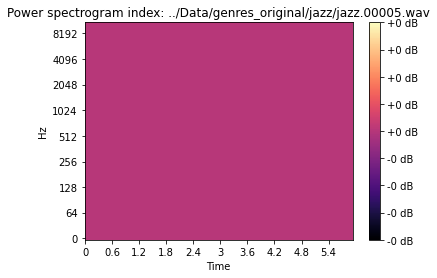

In [288]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def save_sample(batches_done):
    print('batch')
    samples, masked_samples, aux, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    # print(i)
    # y1, x1 = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples = audio_package_fake(filled_samples, i, gen_mask, True)

    
    # filled_samples[:, :, y1 : y1 + mask_size, x1 : x1 + mask_size] = gen_mask
    # Save sample
    # sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    # save_image(sample, "testStuff/%d.png" % batches_done, nrow=6, normalize=True)
    sf.write("fullTestStuff/%d.wav" % batches_done, filled_samples, sr)


    # y = filled_samples

    # S = librosa.stft(y, n_fft=n_fft)

    # img = librosa.display.specshow(S, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)

    # plt.savefig("fullTestStuff/%d.png" % batches_done)



def save_best_sample(batches_done, masked_samples, gen_mask):
    filled_samples = masked_samples.clone()
    filled_samples = audio_package_fake(filled_samples, i, gen_mask, True)
    sf.write(f"best_pixel_loss/{batches_done}.wav", filled_samples, sr)

def modify_sample(batches_done):
    print('batch')
    samples, masked_samples, aux, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    # print(i)
    # y1, x1 = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples = audio_package_fake(filled_samples, i, gen_mask, True)
    # filled_samples[:, :, y1 : y1 + mask_size, x1 : x1 + mask_size] = gen_mask
    # Save sample
    # sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    # save_image(sample, "testStuff/%d.png" % batches_done, nrow=6, normalize=True)
    sf.write("modifyStuff/%d.wav" % batches_done, filled_samples, sr)

def audio_referbish(img, i, gen_mask, prep=False):
    transform = T.Resize(size=(1025, 256))
    transform1 = T.Resize(size=(1025, 25))
    transform2 = T.Resize(size=(1024, 256))
    filled_fake = img.clone()
    filled_fake = transform(filled_fake)
    filled_fake = filled_fake[0][0].numpy()
    gen_mask = transform1(gen_mask)
    gen_mask = gen_mask[0][0].detach()

    # gen_mask[:, 1:3] = 0
    gen_mask = gen_mask.numpy()
    # print(f'this is the shape of gen_mask: {gen_mask.shape}')
    d = librosa.istft(gen_mask, length=mask_size)
    # print(f'this is the length of d: {len(d)}')
    y_out = librosa.istft(filled_fake, length=musicLen)
    # print(f'y_out shape: {y_out.shape}' )
    y_out[i:i+mask_size] = d
    if prep:
        return y_out
    filled_fake =  torch.FloatTensor([[librosa.stft(y_out, n_fft=n_fft)]])
    filled_fake = transform2(filled_fake)
    # filled_fake = Variable(filled_fake.type(Tensor))
    return filled_fake

def package_fake(masked_sample, i, gen_mask):
    y1, x1 = i
    filled_fake = masked_sample.clone()
    filled_fake = Variable(filled_fake.type(Tensor))
    filled_fake[:, :, y1 : y1 + mask_size, x1 : x1 + mask_size] = gen_mask
    return filled_fake

def audio_package_fake(img, i, gen_mask, prep=False):
    transform = T.Resize(size=(1025, 256))
    transform1 = T.Resize(size=(1025, 25))
    transform2 = T.Resize(size=(1024, 256))
    filled_fake = img.clone()
    filled_fake = transform(filled_fake)
    filled_fake = filled_fake[0][0].numpy()
    gen_mask = transform1(gen_mask)
    gen_mask = gen_mask[0][0].detach().numpy()
    # print(f'this is the shape of gen_mask: {gen_mask.shape}')
    d = librosa.istft(gen_mask, length=mask_size)
    # print(f'this is the length of d: {len(d)}')
    y_out = librosa.istft(filled_fake, length=musicLen)
    # print(f'y_out shape: {y_out.shape}' )
    y_out[i:i+mask_size] = d
    if prep:
        return y_out
    filled_fake =  torch.FloatTensor([[librosa.stft(y_out, n_fft=n_fft)]])
    filled_fake = transform2(filled_fake)
    # filled_fake = Variable(filled_fake.type(Tensor))
    return filled_fake

def describe_tensor(tens, str):
    print(str)
    # print(f'tensor: {tens}')
    # print(f'size: {tens.size()}')

    
# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load("saved_models/generatorFull.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminatorFull.pth"))
    print("Using pre-trained Context-Encoder GAN model!")

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)




# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr0, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr0, betas=(b1, b2))

scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G,
    lr_lambda=lambda step: lr_decay(step)/lr0)
scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D,
    lr_lambda=lambda step: lr_decay(step)/lr0)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

my_dis = Discriminator()
w = torch.ones((1, 1, 1024, 256))
z = torch.zeros((1, 1, 1024, patch_w))
D = audio_package_fake(w, 200, z)
D = w.detach().numpy()[0][0]
y = my_dis(x)

S = np.abs(D)
fig, ax = plt.subplots()
img = display.specshow(librosa.amplitude_to_db(S,
                                                    ref=np.max),
                            y_axis='log', x_axis='time', ax=ax)
ax.set_title(f'Power spectrogram index: {sample_path}')
fig.colorbar(img, ax=ax, format="%+2.0f dB")


print(y.shape)
print(patch)


def setTruth(tensor, flip=False):
    # we create a copy of the original tensor, 
    # because of the way we are replacing them.
    res = tensor.clone()

    if flip:
        res[tensor==0], res[tensor==1.0] = 1.0, 0
    else:
        res[tensor!=0] = 1.0
    
    return res







### context encoder advanced

### Simpler version of encoder

In [289]:
gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []
best = 999999
for epoch in range(n_epochs):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for i, (imgs, masked_imgs, masked_parts, index) in enumerate(tqdm_bar):
            
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
        full_valid = Variable(Tensor(imgs.shape[0], *full).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)
 
        # Configure input
        imgs = Variable(imgs.type(Tensor))
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))

        ## Train Generator ##
        optimizer_G.zero_grad()
        # print(masked_imgs.shape)
        # Generate a batch of images
        gen_parts = generator(masked_imgs)
        # describe_tensor(full_gen, 'full_gen')
        # bigFake = package_fake(masked_imgs, index, fake)
        # describe_tensor(bigFake, 'bigfake')

        # print(gen_parts.shape)
        # print(discriminator(gen_parts).size())
        # print(valid.size())

        # Adversarial and pixelwise loss
        # print("MY SHAPES")
        gen = gen_parts

        # print(f"full valid size: ${full_valid.shape}")

        # print(f"fake size: ${fake.shape}")

        # print(f"masked_imgs size: ${masked_imgs.shape}")

        # print(f"gen size: ${fake.shape}")

        package_ground = setTruth(audio_package_fake(masked_imgs.clone(), index, fake.clone()))

        packaged_fake = audio_package_fake(masked_imgs.clone(), index, gen)

        # print(f"package_ground line 1: ${package_ground[0]}")

        # np.savetxt('my_ground.txt', package_ground[0][0].numpy())

        # np.savetxt('my_packaged_fake.txt', packaged_fake[0][0].numpy())

        # print(f"package_ground size: ${package_ground.shape}")

        # print(f"packaged_fake size: ${packaged_fake.shape}")
        
        discrim_result = discriminator(packaged_fake) 
        shape = discrim_result.detach().numpy()[0][0].shape
        # print(shape)
        # print(valid.shape)
        transform = T.Resize(size=shape)
        # print(valid.shape)
        # print(gen.shape)
        # print(discrim_result.shape)
        transform_to_mask_size = T.Resize(size=masked_parts.detach().numpy()[0][0].shape)
        resize_gen= transform_to_mask_size(gen)
        # print(f'resize gen: {resize_gen.shape}')
        # print(f'masked parts: {masked_parts.shape}')

        # np.savetxt('my_packaged_fake.txt', setTruth(package_ground, True)[:, :, 0][0])

        # np.savetxt('my_ground.txt', imgs[0][0])

        # print(imgs[0].detach().shape)

        # print(setTruth(package_ground, True)[:, :, 0].shape)

        
        g_adv = adversarial_loss(discrim_result[0], setTruth(package_ground, True)[:, :, 0])
        g_pixel = pixelwise_loss(resize_gen, masked_parts)
        # Total loss
        g_loss = 0.8 * g_adv + 0.2 * g_pixel

        g_loss.backward()
        optimizer_G.step()
        scheduler_G.step()

        ## Train Discriminator ##
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        # TODO fix this discriminator
        real_discrim = transform(discriminator(imgs))
        gen_discrim = transform(discriminator(packaged_fake.detach()))
        # print(f"real_discrim size: ${real_discrim.shape}")

        # print(f"gen_discrim size: ${gen_discrim.shape}")
        # np.savetxt('my_packaged_fake.txt', full_valid[:, :, 0][0])

        # np.savetxt('my_ground.txt', real_discrim.detach().numpy()[0][0])

        # print(real_discrim[0].shape)

        # print(full_valid[:, :, 0].shape)


        real_loss = adversarial_loss(real_discrim[0], full_valid[:, :, 0])
        fake_loss = adversarial_loss(gen_discrim[0], package_ground[:, :, 0])
        
        d_loss = 0.5 * (real_loss + fake_loss)
        # print(d_loss)

        d_loss.backward()
        optimizer_D.step()
        scheduler_D.step()
        
        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*batch_size +  imgs.size(0) + epoch*len(dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
        # if best > gen_pixel_loss/(i+1):
        #     best = gen_pixel_loss/(i+1)
        #     save_best_sample(str(gen_pixel_loss/(i+1)), masked_imgs, gen_parts.detach())
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print(f"gen_adv_loss = {gen_adv_loss/(i+1)}, gen_pixel_loss = {gen_pixel_loss/(i+1)}, disc_loss = {disc_loss/(i+1)}")
            save_sample(batches_done)
            
    torch.save(generator.state_dict(), "saved_models/generatorFull.pth")
    torch.save(discriminator.state_dict(), "saved_models/discriminatorFull.pth")

Training Epoch 0 :   0%|          | 0/999 [00:00<?, ?it/s]

gen_adv_loss = 0.3123650848865509, gen_pixel_loss = 0.19292135536670685, disc_loss = 0.2841334640979767
batch
gen_adv_loss = 0.8583852698897371, gen_pixel_loss = 8.56519974444504, disc_loss = 0.05464438002298374
batch
gen_adv_loss = 0.8651896870847958, gen_pixel_loss = 4.594706889950851, disc_loss = 0.05165670270943523
batch
gen_adv_loss = 0.8669818183314365, gen_pixel_loss = 3.2596192889393576, disc_loss = 0.050667164605915346
batch
gen_adv_loss = 0.86866819568703, gen_pixel_loss = 2.583458107818926, disc_loss = 0.04981962154779648
batch
gen_adv_loss = 0.8698587154081006, gen_pixel_loss = 2.1732391102565733, disc_loss = 0.04871851295054316
batch
gen_adv_loss = 0.8707911806078799, gen_pixel_loss = 1.91269135343867, disc_loss = 0.04765650607062854
batch
gen_adv_loss = 0.8713072559207721, gen_pixel_loss = 1.7277957452457802, disc_loss = 0.04684662450896775
batch
gen_adv_loss = 0.872172427571817, gen_pixel_loss = 1.579754208188711, disc_loss = 0.04584855103769925
batch
gen_adv_loss = 0.87

Training Epoch 1 :   0%|          | 0/999 [00:00<?, ?it/s]

gen_adv_loss = 0.881164014339447, gen_pixel_loss = 0.9242343008518219, disc_loss = 0.03598024696111679
batch
gen_adv_loss = 0.8872020706242206, gen_pixel_loss = 0.5986194616074071, disc_loss = 0.03273970631919071
batch
gen_adv_loss = 0.8884021976206562, gen_pixel_loss = 0.5709198752076983, disc_loss = 0.03234515382474897
batch


KeyboardInterrupt: 

### spectrogram

In [ ]:
root = './fullTestStuff'

save_sample(9999999)

files = sorted(glob.glob("%s/*" % root))
print(len(files))
for file in files:
    y, sr = librosa.load(file)
    D = librosa.stft(y)
    S = np.abs(D)
    fig, ax = plt.subplots()
    img = display.specshow(librosa.amplitude_to_db(S,
                                                        ref=np.max),
                                y_axis='log', x_axis='time', ax=ax)
    ax.set_title(f'Power spectrogram index: {file}')
    fig.colorbar(img, ax=ax, format="%+2.0f dB")


blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.6, 0.6))


sample_path = './allGenresSuccess2/990.wav'


y, sr = librosa.load(sample_path)

D = torch.FloatTensor([librosa.stft(y, n_fft=n_fft)])

D = blurrer(D)
D = D[0].numpy()

# D[600:-10] = 0
y_out = librosa.istft(D, length=musicLen)
sf.write("modifyStuff/%d.wav" % 69, y_out, sr)
S = np.abs(D)
fig, ax = plt.subplots()
img = display.specshow(librosa.amplitude_to_db(S,
                                                    ref=np.max),
                            y_axis='log', x_axis='time', ax=ax)
ax.set_title(f'Power spectrogram index: {sample_path}')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# print(gen_pixel_losses)



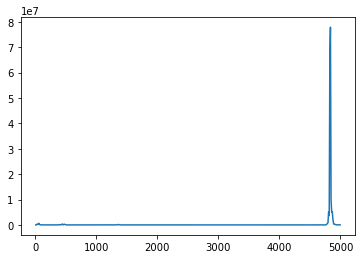

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=gen_adv_losses, mode='lines', name='Gen Adv Loss'))

fig.update_layout(
    width=1000,
    height=500,
    title="Generator Adversarial Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Gen Adversarial Loss (MSELoss)"),
fig.show()

plt.plot(counter, gen_adv_losses) 

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=counter, y=gen_pixel_losses, mode='lines', name='Gen Pixel Loss', marker_color='orange'))

fig.update_layout(
    width=1000,
    height=500,
    title="Generator Pixel Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Gen Pixel Loss (L1 Loss)"),
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=disc_losses, mode='lines', name='Discriminator Loss', marker_color='seagreen'))

fig.update_layout(
    width=1000,
    height=500,
    title="Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Disc Loss (MSELoss)"),
fig.show()

### Work in Progress ...